# Dataset

In [1]:
!wget https://raw.githubusercontent.com/1297rohit/RCNN/master/Images.zip

--2023-10-20 16:26:38--  https://raw.githubusercontent.com/1297rohit/RCNN/master/Images.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12680736 (12M) [application/zip]
Saving to: ‘Images.zip’

Images.zip          100%[===================>]  12.09M  --.-KB/s    in 0.08s   

2023-10-20 16:26:39 (151 MB/s) - ‘Images.zip’ saved [12680736/12680736]



# Image Annotations

In [2]:
!wget https://raw.githubusercontent.com/1297rohit/RCNN/master/Airplanes_Annotations.zip

--2023-10-20 16:26:40--  https://raw.githubusercontent.com/1297rohit/RCNN/master/Airplanes_Annotations.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 181072 (177K) [application/zip]
Saving to: ‘Airplanes_Annotations.zip’

Airplanes_Annotatio 100%[===================>] 176.83K  --.-KB/s    in 0.03s   

2023-10-20 16:26:40 (6.84 MB/s) - ‘Airplanes_Annotations.zip’ saved [181072/181072]



# Sklearn

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

# Unzip the Images and Annotations

In [ ]:
!unzip Images.zip

In [ ]:
!unzip Airplanes_Annotations.zip

# Visulations

In [5]:
!cat /content/Airplanes_Annotations/42845.csv

4
15 69 40 96
10 173 42 203
74 212 100 243
233 197 256 226


# Libraries

In [6]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Tensorflow

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16

# Path and annotations

In [8]:
path = '/content/Images'
annot = '/content/Airplanes_Annotations'

In [9]:
map = os.listdir(annot)
file_paths = [os.path.join(annot, filename) for filename in map]

In [ ]:
dfs = []
for file in file_paths:
  df = pd.read_csv(file)
  dfs.append(df)
print(dfs)

In [11]:
combined_df = pd.concat(dfs, ignore_index=True)

airplane_501.jpg


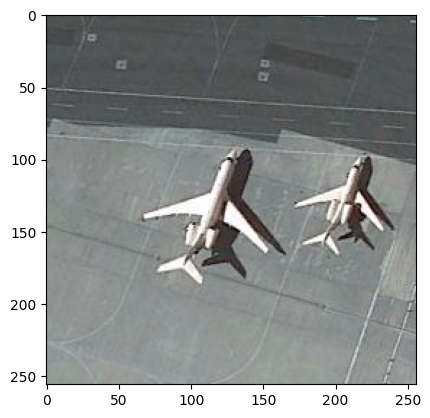

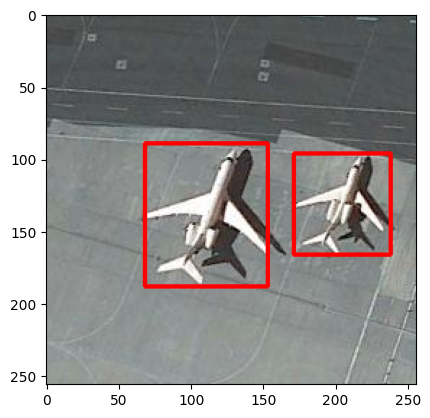

In [13]:
for i,j in enumerate(os.listdir(annot)):
  if i<10:
    filename = j.split(".")[0]+".jpg"
    print(filename)
    img = cv2.imread(os.path.join(path, filename))
    df = pd.read_csv(os.path.join(annot,j))
    plt.imshow(img)
    for row in df.iterrows():
      x1 = int(row[1][0].split(" ")[0])
      y1 = int(row[1][0].split(" ")[1])
      x2 = int(row[1][0].split(" ")[2])
      y2 = int(row[1][0].split(" ")[3])
      cv2.rectangle(img, (x1,y1), (x2,y2), (255,0,0), 2)
    plt.figure()
    plt.imshow(img)
    break
plt.show()

In [14]:
cv2.setUseOptimized(True)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

---------------
[[201 185  11  71]
 [ 33  12  23  18]
 [ 25 186  59  57]
 ...
 [145   0 111 256]
 [208   0  48 256]
 [ 32   0 192 123]]


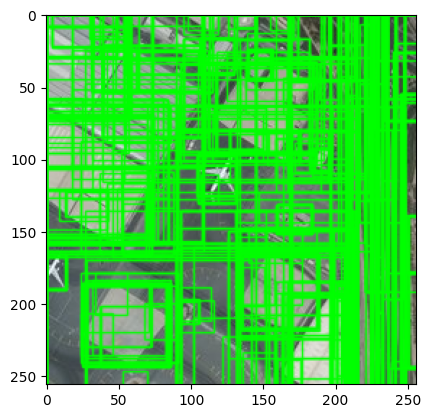

In [15]:
img = cv2.imread(os.path.join(path, "42850.jpg"))
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
rects = ss.process()
print('---------------')
print(rects)
imout = img.copy()
for i, rect in enumerate(rects):
  x,y,w,h = rect
  #print(x,y,w,h)
  cv2.rectangle(imout, (x,y), (x+w, y+h), (0,255,0), 1, cv2.LINE_AA)
plt.imshow(cv2.cvtColor(imout, cv2.COLOR_BGR2RGB))
plt.show()

In [16]:
train_images = []
train_labels = []

# Intersection of Union

In [17]:
def get_iou(bb1, bb2):
  assert bb1['x1'] < bb1['x2']
  assert bb1['y1'] < bb1['y2']
  assert bb2['x1'] < bb1['x2']
  assert bb2['y1'] < bb1['y2']

  x_left = max(bb1['x1'], bb2['x1'])
  y_top = max(bb1['y1'], bb2['y1'])
  x_right = min(bb1['x2'], bb2['x2'])
  y_bottom = min(bb1['y2'], bb2['y2'])

  if x_right < x_left or y_bottom < y_top:
    return 0.0

  intersection_area = (x_right - x_left) * (y_bottom - y_top)

  bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
  bb2_area = (bb2['x2'] - bb2['x1'] * (bb2['y2'] - bb2['y1']))

  iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
  assert iou >= 0.0
  assert iou <= 1.0
  return iou

In [19]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [34]:
for i in os.listdir(annot):
  out = i.split(".")[0]+".jpg"
  #if i.startswith("airplane"):
    #print(True)
print(out)

airplane_652.jpg


# Training and Testing

In [35]:
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for e,result in enumerate(ssresults):
              if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.70:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

0 airplane_501.jpg

error in airplane_501.jpg
1 airplane_366.jpg

error in airplane_366.jpg
2 airplane_086.jpg

error in airplane_086.jpg
3 airplane_587.jpg

error in airplane_587.jpg
4 airplane_209.jpg

error in airplane_209.jpg
6 airplane_235.jpg

error in airplane_235.jpg
7 airplane_507.jpg

error in airplane_507.jpg
8 airplane_109.jpg

error in airplane_109.jpg
9 airplane_413.jpg

error in airplane_413.jpg
10 airplane_664.jpg

error in airplane_664.jpg
11 airplane_499.jpg

error in airplane_499.jpg
12 airplane_342.jpg

error in airplane_342.jpg
14 airplane_032.jpg

error in airplane_032.jpg
15 airplane_256.jpg

error in airplane_256.jpg
16 airplane_358.jpg

error in airplane_358.jpg
17 airplane_488.jpg

error in airplane_488.jpg
18 airplane_408.jpg

error in airplane_408.jpg
19 airplane_432.jpg

error in airplane_432.jpg
20 airplane_103.jpg

error in airplane_103.jpg
21 airplane_073.jpg

error in airplane_073.jpg
22 airplane_526.jpg

error in airplane_526.jpg
23 airplane_050.jpg

e

In [36]:
x_new = np.array(train_images)
y_new = np.array(train_labels)

In [42]:
x_new.shape, y_new.shape

((598, 224, 224, 3), (598,))

# Model building

In [44]:
vggmodel = VGG16(weights='imagenet', include_top=True)
vggmodel.summary()

553467096/553467096 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [45]:
for layers in (vggmodel.layers)[:15]:
  print(layers)
  layers.trainable = False

In [46]:
x = vggmodel.layers[-2].output

In [47]:
predictions = Dense(2, activation='softmax')(x)

In [51]:
model_final = Model(vggmodel.input, predictions)

In [54]:
optimizer = optimizers.Adam(learning_rate=0.001)

In [67]:
model_final.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [68]:
model_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [69]:
lr = LabelBinarizer()

In [70]:
y_new = lr.fit_transform(y_new)

In [71]:
x_train, x_test, y_train, y_test = train_test_split(x_new, y_new, test_size=0.2)

In [72]:
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=x_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=x_test, y=y_test)

In [73]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [74]:
checkpoint = ModelCheckpoint('rcnn_vgg.h5', monitor='val_loss', verbose=1, save_best_only=True )
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [75]:
history = model_final.fit(traindata, batch_size=32, epochs=100, validation_data=testdata)

Epoch 1/100
15/15 [==============================] - 10s 634ms/step - loss: 875234368.0000 - accuracy: 0.4644 - val_loss: 6601249280.0000 - val_accuracy: 1.0000
Epoch 2/100
15/15 [==============================] - 8s 541ms/step - loss: 20316608512.0000 - accuracy: 0.4686 - val_loss: 34564419584.0000 - val_accuracy: 1.0000
Epoch 3/100
15/15 [==============================] - 7s 474ms/step - loss: 89140363264.0000 - accuracy: 0.6025 - val_loss: 430419476480.0000 - val_accuracy: 0.0000e+00
Epoch 4/100
15/15 [==============================] - 8s 542ms/step - loss: 470397190144.0000 - accuracy: 0.4017 - val_loss: 617562636288.0000 - val_accuracy: 1.0000
Epoch 5/100
15/15 [==============================] - 8s 544ms/step - loss: 2465185398784.0000 - accuracy: 0.5314 - val_loss: 2213984075776.0000 - val_accuracy: 0.0000e+00
Epoch 6/100
15/15 [==============================] - 7s 482ms/step - loss: 10712816549888.0000 - accuracy: 0.5314 - val_loss: 13915121516544.0000 - val_accuracy: 0.0000e+00

# Plot accuracy

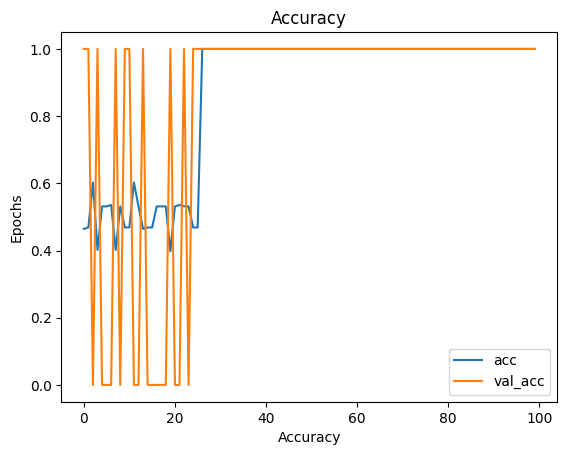

In [77]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Epochs')
plt.legend(['acc', 'val_acc'])
plt.show()

# Plot loss

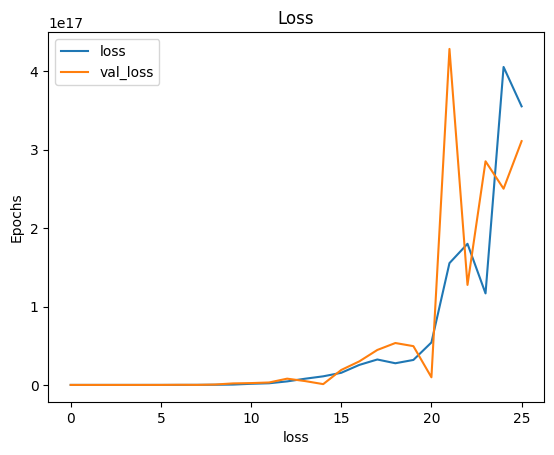

In [79]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('loss')
plt.ylabel('Epochs')
plt.legend(['loss', 'val_loss'])
plt.show()

1/1 [==============================] - 1s 985ms/step
Not plane


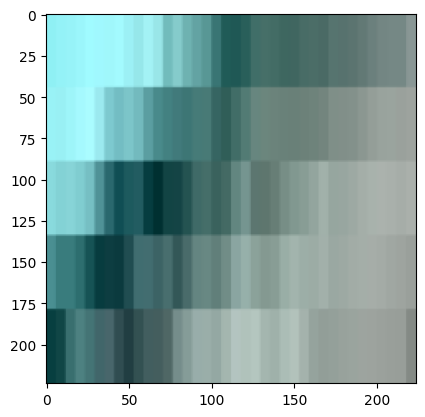

In [83]:
im = x_test[1]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out = model_final.predict(img)
if out[0][0] > out[0][1]:
  print('Plane')
else:
  print('Not plane')

1/1 [==============================] - 0s 25ms/step


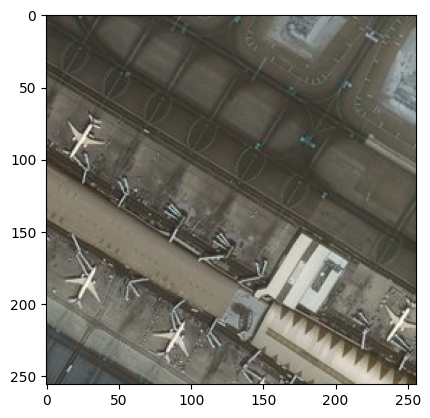

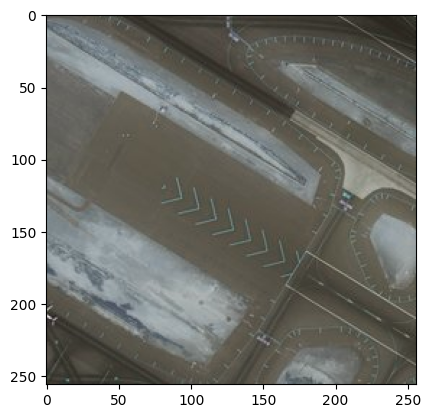

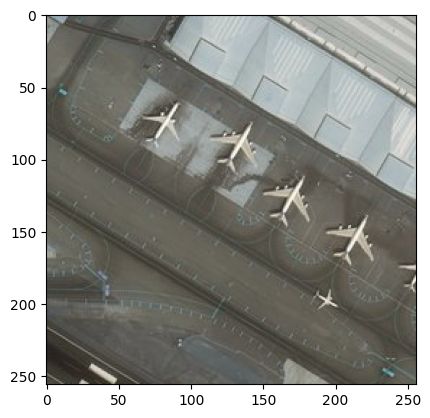

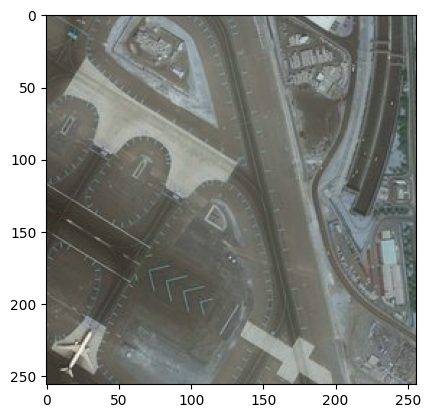

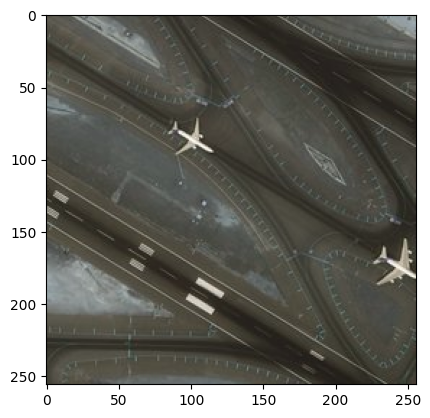

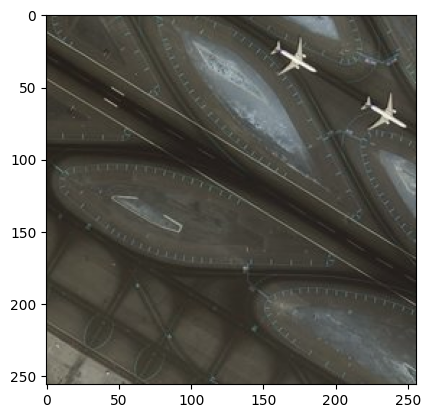

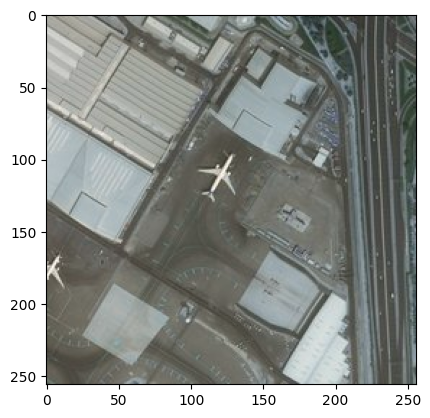

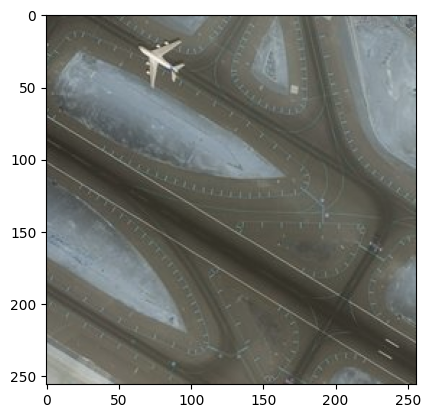

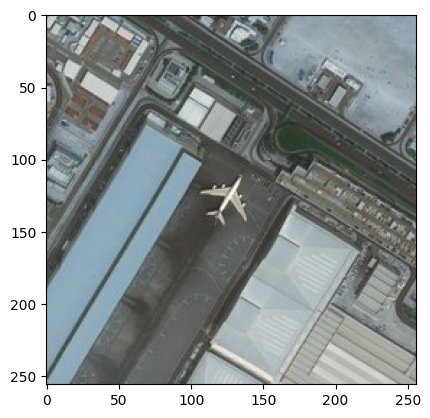

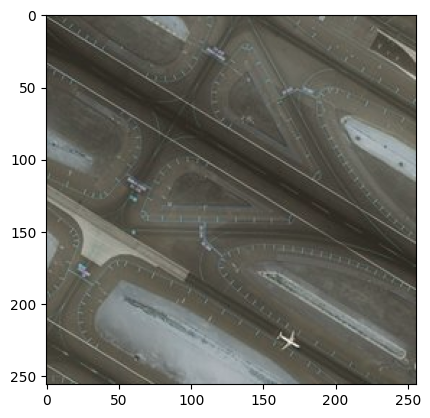

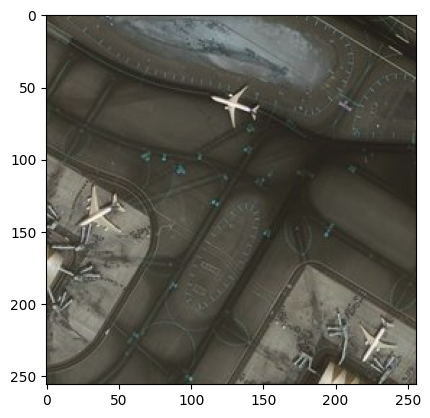

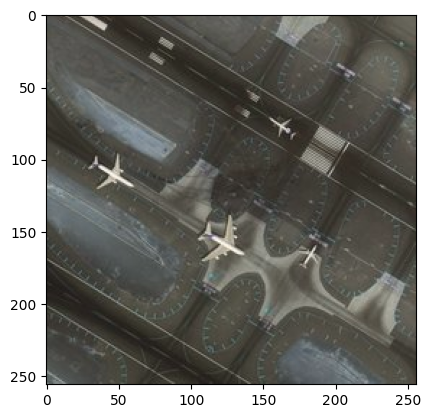

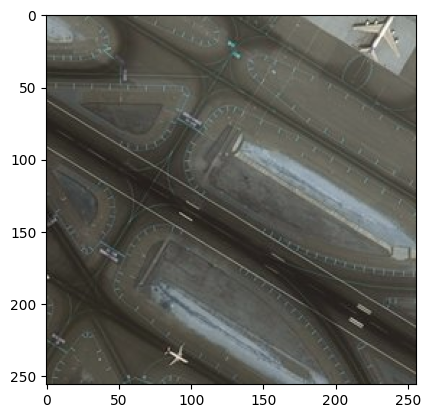

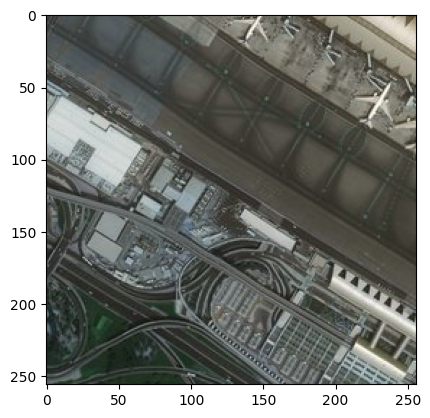

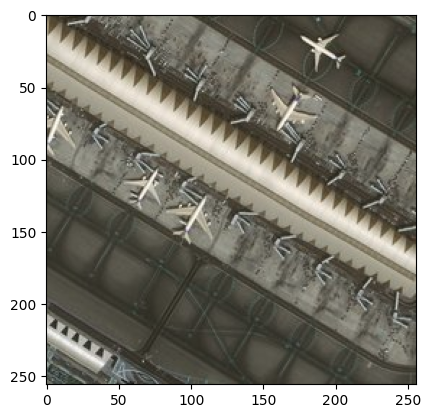

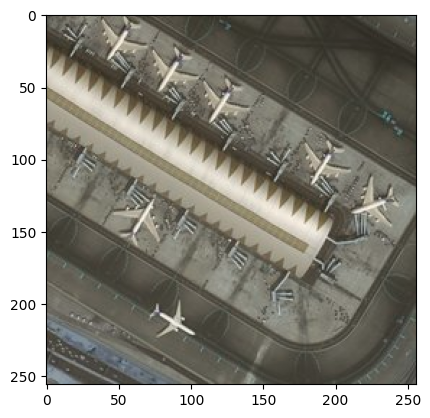

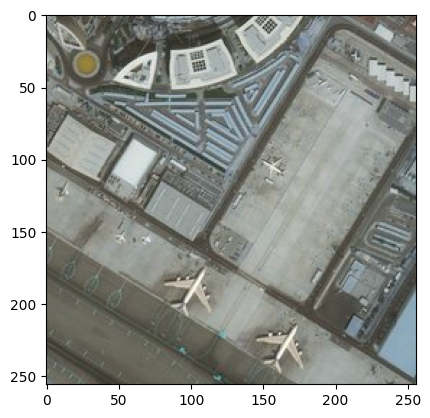

In [85]:
z=0
for e,i in enumerate(os.listdir(path)):
    if i.startswith("4"):
        z += 1
        img = cv2.imread(os.path.join(path,i))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        imout = img.copy()
        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model_final.predict(img)
                if out[0][0] > 0.3:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        plt.figure()
        plt.imshow(imout)